In [28]:
# ==============================================================================
# CELL 1: ENVIRONMENT SETUP & DEPENDENCIES
# ==============================================================================

import os
from dotenv import load_dotenv
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import spacy

# 1. LOAD ENVIRONMENT VARIABLES
load_success = load_dotenv()
if load_success:
    print(f"✅ Environment variables loaded from .env")
else:
    print(f"⚠️ Warning: .env file not found or empty.")

# 2. CONSTRUCT DATABASE CONNECTION
# Fetch individual parts from your specific .env structure
db_user = os.getenv("DB_USER")
db_pass = os.getenv("DB_PASS")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name = os.getenv("DB_NAME")

# Verify we have everything (except password, which might be empty for local dev sometimes)
if not all([db_user, db_host, db_name]):
    print("❌ Error: Missing DB_USER, DB_HOST, or DB_NAME in .env file.")
else:
    # Build the SQLAlchemy connection string: postgresql://<user>:<pass>@<host>:<port>/<db>
    # We use f-strings to assemble it dynamically
    DB_STRING = f"postgresql://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}"
    
    try:
        # Create Engine
        engine = create_engine(DB_STRING)
        
        # Test Connection
        with engine.connect() as conn:
            print(f"✅ Database connection established to {db_host}")
            
    except Exception as e:
        print(f"❌ Database connection failed. Check your password in .env.")
        print(f"   Error details: {e}")

# 3. SPACY MODEL CHECK
try:
    nlp = spacy.load("en_core_web_sm")
    print("✅ spaCy model 'en_core_web_sm' loaded.")
except OSError:
    print("❌ spaCy model not found. Run 'python -m spacy download en_core_web_sm' in terminal.")

# 4. CONFIGURATION
pd.set_option('display.max_colwidth', None)
print("🚀 Setup Complete.")

✅ Environment variables loaded from .env
✅ Database connection established to db.nfrqwoqhwncixlqkpvwl.supabase.co
✅ spaCy model 'en_core_web_sm' loaded.
🚀 Setup Complete.


In [29]:
# ==============================================================================
# CELL 2: LOAD KNOWLEDGE GRAPH (ENTITY RULER) - FIXED
# ==============================================================================
import json
import os
from spacy.pipeline import EntityRuler

# 1. SETUP ENTITY RULER
# Remove old ruler if it exists to prevent duplicate rules
if "entity_ruler" in nlp.pipe_names:
    nlp.remove_pipe("entity_ruler")
    
# Create new ruler and place it BEFORE the NER component
# (This ensures "The Shire" is caught as a Location, not ignored)
ruler = nlp.add_pipe("entity_ruler", before="ner")

# 2. DEFINE FILE MANIFEST
entity_files = [
    "lotr_entities.json",          # WHO (Lore)
    "vg_entities.json",    # WHAT (Games)
    "vg_mechanics.json",              # HOW (Mechanics)
    "vg_aesthetics.json",             # VIBE (Aesthetics)
    "vg_tech.json"                    # CONTEXT (Tech)
]

# 3. PARSE & LOAD PATTERNS
patterns = []
print(f"--- LOADING KNOWLEDGE GRAPH ---")

for filename in entity_files:
    if not os.path.exists(filename):
        print(f"⚠️ Warning: {filename} not found. Skipping.")
        continue
        
    with open(filename, 'r') as f:
        data = json.load(f)
        
    # A. GAMES (Array of objects with regex)
    if "games" in data: 
        for game in data["games"]:
            # Use Regex if available, otherwise exact string
            pat = [{"TEXT": {"REGEX": game["regex_pattern"]}}] if "regex_pattern" in game else game["canonical_name"]
            patterns.append({"label": "GAME", "pattern": pat, "id": game["slug"]})
        print(f"✅ Loaded {len(data['games'])} Games from {filename}")

    # B. LOTR ENTITIES (Nested Dictionary)
    elif "characters" in data: 
        # We use a mutable dict to track count, avoiding 'nonlocal' scope errors
        stats = {"count": 0} 
        
        def parse_lotr(node):
            if isinstance(node, list):
                for item in node:
                    if isinstance(item, dict) and "canonical" in item:
                        patterns.append({"label": "LOTR_ENTITY", "pattern": item["canonical"], "id": item["canonical"]})
                        for alias in item.get("aliases", []):
                            patterns.append({"label": "LOTR_ENTITY", "pattern": alias, "id": item["canonical"]})
                        stats["count"] += 1
            elif isinstance(node, dict):
                for val in node.values(): 
                    parse_lotr(val)
                    
        parse_lotr(data)
        print(f"✅ Loaded ~{stats['count']} LOTR Entities from {filename}")

    # C. CONTEXT CONCEPTS (Mechanics/Tech/Aesthetics)
    elif "entities" in data:
        label = data.get("label", "CONCEPT")
        for item in data["entities"]:
            patterns.append({"label": label, "pattern": item["canonical"], "id": item["canonical"]})
            for alias in item["aliases"]:
                patterns.append({"label": label, "pattern": alias, "id": item["canonical"]})
        print(f"✅ Loaded {len(data['entities'])} {label} concepts from {filename}")

# 4. COMMIT TO PIPELINE
ruler.add_patterns(patterns)
print(f"\n🚀 PIPELINE READY: {len(patterns)} patterns active.")

--- LOADING KNOWLEDGE GRAPH ---
✅ Loaded ~179 LOTR Entities from lotr_entities.json
✅ Loaded 85 Games from vg_entities.json
✅ Loaded 22 MECHANIC concepts from vg_mechanics.json
✅ Loaded 9 AESTHETIC concepts from vg_aesthetics.json
✅ Loaded 10 TECH concepts from vg_tech.json

🚀 PIPELINE READY: 848 patterns active.


In [30]:
# ==============================================================================
# CELL 3: DATA INGESTION (VERIFIED HUMANS WITH POST CONTEXT)
# ==============================================================================

import pandas as pd

# Stage 1: Pull comments from verified human authors
print("⏳ Stage 1: Pulling comments from verified authors...")

comments_sql = """
SELECT 
    rc.id as comment_id,
    rc.subreddit,
    rc.author,
    rc.content,
    rc.score,
    rc.created_at,
    rc.post_id
FROM reddit_comments rc
JOIN user_authenticity_cache uac ON rc.author = uac.author
WHERE rc.subreddit IN ('lotr','tolkienfans','LOTR_on_Prime','lordoftherings','Rings_Of_Power','lotro','TalesofTheShiregamers','lotrlcg','TheWarOfTheRohirrim','lotrmemes','Eldenring','skyrim','witcher','Witcher3','baldursgate','BG3','BaldursGate3','darksouls','darksouls3','Sekiro','fromsoftware','zelda','FinalFantasyVII','Genshin_Impact','reddeadredemption','wow','warcraftlore','ffxiv','Destiny','gaming','gamingsuggestions','videogames','GamingLeaksAndRumours','CozyGamers','CallOfDuty','apexlegends','leagueoflegends','VALORANT','pokemongo','FortNiteBR','Minecraft','GTA','StardewValley','VampireSurvivors','Warframe','ArcRaiders','southpark','Fantasy','Medievalart','bladerunner','FanFiction','movies','Music','TheSimpsons','cinematography','Filmmakers','writing')
AND rc.is_deleted = FALSE
AND uac.authenticity_score IN ('HIGH', 'MEDIUM');
"""

df_comments = pd.read_sql(comments_sql, engine)
print(f"✅ Pulled {len(df_comments):,} comments")
print(f"   Unique posts: {df_comments['post_id'].nunique():,}")
print(f"   Unique authors: {df_comments['author'].nunique():,}")
print(f"   Subreddits: {df_comments['subreddit'].nunique()}")

# Stage 2: Fetch post titles
print("\n⏳ Stage 2: Fetching post titles...")

post_ids = df_comments['post_id'].dropna().unique().tolist()
print(f"   Need titles for {len(post_ids):,} posts")

batch_size = 5000
all_posts = []

for i in range(0, len(post_ids), batch_size):
    batch = post_ids[i:i+batch_size]
    placeholders = ','.join([f"'{p}'" for p in batch])
    posts_sql = f"SELECT post_id, title FROM reddit_posts WHERE post_id IN ({placeholders})"
    df_batch = pd.read_sql(posts_sql, engine)
    all_posts.append(df_batch)
    print(f"   Batch {i//batch_size + 1}: {len(df_batch):,} posts")

df_posts = pd.concat(all_posts, ignore_index=True) if all_posts else pd.DataFrame(columns=['post_id', 'title'])
print(f"✅ Fetched {len(df_posts):,} post titles")

# Stage 3: Merge
print("\n⏳ Stage 3: Merging...")
df_raw = df_comments.merge(df_posts, on='post_id', how='left')
df_raw.rename(columns={'title': 'post_title'}, inplace=True)

print(f"\n{'='*50}")
print(f"✅ FINAL DATASET: {len(df_raw):,} comments")
print(f"   With post titles: {df_raw['post_title'].notna().sum():,}")
print(f"   Unique authors: {df_raw['author'].nunique():,}")
print(f"   Date range: {df_raw['created_at'].min()} to {df_raw['created_at'].max()}")
print(f"\n📊 Top subreddits:")
print(df_raw['subreddit'].value_counts().head(10))

⏳ Stage 1: Pulling comments from verified authors...
✅ Pulled 133,586 comments
   Unique posts: 24,798
   Unique authors: 6,428
   Subreddits: 56

⏳ Stage 2: Fetching post titles...
   Need titles for 24,798 posts
   Batch 1: 4,992 posts
   Batch 2: 4,995 posts
   Batch 3: 4,796 posts
   Batch 4: 4,987 posts
   Batch 5: 4,718 posts
✅ Fetched 24,488 post titles

⏳ Stage 3: Merging...

✅ FINAL DATASET: 133,586 comments
   With post titles: 133,101
   Unique authors: 6,428
   Date range: 2021-11-20 21:29:30+00:00 to 2026-01-27 16:41:56+00:00

📊 Top subreddits:
subreddit
tolkienfans       16621
warcraftlore      12927
lotr              12200
LOTR_on_Prime      8237
witcher            5975
baldursgate        5532
Music              5364
Rings_Of_Power     4658
movies             4566
Fantasy            4495
Name: count, dtype: int64


In [32]:
# ==============================================================================
# CELL 3b: PULL ALL POSTS FOR CLASSIFICATION
# ==============================================================================

import pandas as pd

print("⏳ Pulling posts from target subreddits...")

posts_sql = """
SELECT 
    post_id,
    subreddit,
    title,
    content,
    url,
    score,
    num_comments,
    created_at
FROM reddit_posts
WHERE subreddit IN ('lotr','tolkienfans','LOTR_on_Prime','lordoftherings','Rings_Of_Power','lotro','TalesofTheShiregamers','lotrlcg','TheWarOfTheRohirrim','lotrmemes','Eldenring','skyrim','witcher','Witcher3','baldursgate','BG3','BaldursGate3','darksouls','darksouls3','Sekiro','fromsoftware','zelda','FinalFantasyVII','Genshin_Impact','reddeadredemption','wow','warcraftlore','ffxiv','Destiny','gaming','gamingsuggestions','videogames','GamingLeaksAndRumours','CozyGamers')
ORDER BY score DESC;
"""

df_posts = pd.read_sql(posts_sql, engine)

# Classify post type based on content
df_posts['post_type'] = df_posts.apply(lambda row: 
    'TEXT' if pd.notna(row['content']) and len(str(row['content'])) > 10
    else 'LINK' if pd.notna(row['url']) and 'reddit.com' not in str(row['url'])
    else 'IMAGE' if pd.notna(row['url']) and any(x in str(row['url']) for x in ['i.redd.it', 'imgur', '.jpg', '.png', '.gif'])
    else 'OTHER',
    axis=1
)

print(f"✅ Pulled {len(df_posts):,} posts")
print(f"\n📊 By subreddit:")
print(df_posts['subreddit'].value_counts().head(15))
print(f"\n📊 By post type:")
print(df_posts['post_type'].value_counts())
print(f"\n📊 Sample titles:")
for _, row in df_posts.head(10).iterrows():
    print(f"  [{row['subreddit']}] {row['title'][:80]}")

⏳ Pulling posts from target subreddits...
✅ Pulled 30,297 posts

📊 By subreddit:
subreddit
lotr                 2991
Genshin_Impact       1293
tolkienfans          1261
LOTR_on_Prime        1214
gamingsuggestions    1192
videogames           1157
Destiny              1095
Eldenring            1094
darksouls3           1032
lordoftherings       1027
lotro                1026
zelda                1016
BG3                  1012
lotrlcg              1011
FinalFantasyVII      1007
Name: count, dtype: int64

📊 By post type:
post_type
TEXT     24299
LINK      4812
OTHER     1186
Name: count, dtype: int64

📊 Sample titles:
  [lotr] Absolutely pathetic from the Academy.
  [lotr] Flag of Gondor spotted during anti-government protest in Budapest, Hungary, 10.0
  [skyrim] Fulfilled a childhood dream of mine and painted Whiterun at "lore scale"
  [lotr] After just under 31hrs, my Narsil tattoo is complete!
  [lotr] UPDATE: I met Faramir today!
  [lotr] The dedication from Karl Urban is amazing.
  [

In [33]:
# ==============================================================================
# CELL 3c: EXPLORE POST TITLES FOR INTENT PATTERNS
# ==============================================================================

# Look for question posts (most likely to have discussion value)
question_posts = df_posts[df_posts['title'].str.contains(r'\?', regex=True)]
print(f"📊 Posts with questions: {len(question_posts):,} ({len(question_posts)/len(df_posts)*100:.1f}%)")

# Sample question posts by subreddit type
print("\n--- LOTR SUBREDDIT QUESTIONS (sample) ---")
lotr_subs = ['lotr', 'tolkienfans', 'LOTR_on_Prime', 'lordoftherings', 'Rings_Of_Power', 'lotro']
lotr_questions = question_posts[question_posts['subreddit'].isin(lotr_subs)].head(20)
for _, row in lotr_questions.iterrows():
    print(f"  [{row['subreddit']}] {row['title'][:100]}")

print("\n--- GAMING SUBREDDIT QUESTIONS (sample) ---")
gaming_subs = ['gaming', 'gamingsuggestions', 'videogames', 'Eldenring', 'BG3', 'skyrim', 'witcher']
gaming_questions = question_posts[question_posts['subreddit'].isin(gaming_subs)].head(20)
for _, row in gaming_questions.iterrows():
    print(f"  [{row['subreddit']}] {row['title'][:100]}")

📊 Posts with questions: 9,154 (30.2%)

--- LOTR SUBREDDIT QUESTIONS (sample) ---
  [lotr] Can we just appreciate how insanely technically impressive this shot is? The Camera Tracks all the w
  [lotr] Genuine question. Why is the Hobbit trilogy so disliked by so many people? It may be a hot take but 
  [lotr] The Lord of the Rings is often hailed as the greatest story/work of fiction ever but which other sto
  [lotr] Who are these two men?
  [lotr] Meeting Faramir tomorrow. What should I say?
  [lotr] Who would you gift this to?
  [lotr] Did anyone else dress up for the re-release? 🥲
  [lotr] For some reason, this soldier has always stood out to me. Do y’all have that one background characte
  [lotr] How did Smaug move all the gold into one place?
  [lotr] Anyone else can’t stop laughing at this scene?
  [lotr] No.5: Who is the morally gray character that people have divided opinions about?
  [lotr] What makes the Fellowship of the Ring stand out from Two Towers and Return of the King?


In [34]:
# ==============================================================================
# CELL 3d: FIND HIGH-VALUE DISCUSSION POSTS
# ==============================================================================

# Define patterns that indicate valuable discussion types
wishlist_patterns = r'(?i)(what would you want|dream game|wish they|should make|features you|would you like to see|what.+need|hope they|want.*sequel|want.*game)'
pain_point_patterns = r'(?i)(worst thing|ruined|failed|why did.+fail|problem with|hate about|disappointed|what.+wrong|unpopular opinion|hot take)'
comparison_patterns = r'(?i)(vs\.?|versus|better than|compared to|best.+game|favorite.+game|top \d|ranking|tier list)'
recommendation_patterns = r'(?i)(games like|looking for|recommend|suggest|similar to|if you liked)'

df_posts['is_wishlist'] = df_posts['title'].str.contains(wishlist_patterns, regex=True, na=False)
df_posts['is_pain_point'] = df_posts['title'].str.contains(pain_point_patterns, regex=True, na=False)
df_posts['is_comparison'] = df_posts['title'].str.contains(comparison_patterns, regex=True, na=False)
df_posts['is_recommendation'] = df_posts['title'].str.contains(recommendation_patterns, regex=True, na=False)

print("📊 HIGH-VALUE POST COUNTS:")
print(f"   Wishlist posts: {df_posts['is_wishlist'].sum()}")
print(f"   Pain point posts: {df_posts['is_pain_point'].sum()}")
print(f"   Comparison posts: {df_posts['is_comparison'].sum()}")
print(f"   Recommendation posts: {df_posts['is_recommendation'].sum()}")

print("\n--- WISHLIST POSTS (sample) ---")
for _, row in df_posts[df_posts['is_wishlist']].head(15).iterrows():
    print(f"  [{row['subreddit']}] ({row['num_comments']} comments) {row['title'][:90]}")

print("\n--- PAIN POINT POSTS (sample) ---")
for _, row in df_posts[df_posts['is_pain_point']].head(15).iterrows():
    print(f"  [{row['subreddit']}] ({row['num_comments']} comments) {row['title'][:90]}")

print("\n--- COMPARISON POSTS (sample) ---")
for _, row in df_posts[df_posts['is_comparison']].head(15).iterrows():
    print(f"  [{row['subreddit']}] ({row['num_comments']} comments) {row['title'][:90]}")

/var/folders/yp/4_xz98d14gvf_j5k1mwz3f940000gn/T/ipykernel_64040/1565013628.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_posts['is_wishlist'] = df_posts['title'].str.contains(wishlist_patterns, regex=True, na=False)
/var/folders/yp/4_xz98d14gvf_j5k1mwz3f940000gn/T/ipykernel_64040/1565013628.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_posts['is_pain_point'] = df_posts['title'].str.contains(pain_point_patterns, regex=True, na=False)
/var/folders/yp/4_xz98d14gvf_j5k1mwz3f940000gn/T/ipykernel_64040/1565013628.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_posts['is_comparison'] = df_posts['title'].str.contains(comparison_patterns, regex=True, na=False)
/var/folders/yp/4_xz98d14gvf_j5k1mwz3f940000

📊 HIGH-VALUE POST COUNTS:
   Wishlist posts: 78
   Pain point posts: 129
   Comparison posts: 561
   Recommendation posts: 1020

--- WISHLIST POSTS (sample) ---
  [Genshin_Impact] (178 comments) I'm the creator of Genshin PvP, I want to clarify a few things and ask for feedback for ba
  [Destiny] (265 comments) Tim Walz: "I'll continue to ask you for peace and I know the answer is, 'You ask us for pe
  [Witcher3] (46 comments) Everyone talking about what they hope comes with TW4.. I hope they don’t over compensate t
  [wow] (46 comments) I hope they do more Warband Campsites.
  [Witcher3] (12 comments) These Redanians wish they could hang with Geralt of Dripia.
  [zelda] (84 comments) [ALL] I was laid off from my job this year, and I'm now making my dream game inspired by L
  [Genshin_Impact] (87 comments) i hope they buff my boy soon
  [skyrim] (102 comments) Is it possible to be an evil Orc that hates humanity and wants them all gone? Like how man
  [CozyGamers] (75 comments) I want 

In [35]:
# ==============================================================================
# CELL 3e: EXPLORE RECOMMENDATION POSTS
# ==============================================================================

print("--- RECOMMENDATION POSTS (sample) ---")
rec_posts = df_posts[df_posts['is_recommendation']].sort_values('num_comments', ascending=False)

for _, row in rec_posts.head(30).iterrows():
    print(f"  [{row['subreddit']}] ({row['num_comments']} comments) {row['title'][:95]}")

print(f"\n📊 Recommendation posts by subreddit:")
print(rec_posts['subreddit'].value_counts().head(10))

--- RECOMMENDATION POSTS (sample) ---
  [gamingsuggestions] (1594 comments) Looking for insanely complex games that basically REQUIRE a wiki to finish
  [gaming] (1047 comments) Name a game you love but can't recommend to everyone
  [gaming] (799 comments) I need someone to recommend me a banger
  [videogames] (744 comments) Which game did someone recommend and made you feel like this
  [CozyGamers] (254 comments) Recommend me your favorite cozy Switch game 💙🩷🤍
  [gamingsuggestions] (228 comments) DEPRESSED and looking for a new IMMERSIVE CONTENT RICH hyper-fixation
  [gamingsuggestions] (222 comments) Looking for games to play with MY STRICT friend
  [darksouls] (160 comments) Looking for advice from people who initially hated/were massively frustrated by DS1 but somehow
  [CozyGamers] (156 comments) I need some suggestions for Nintendo Switch for a new gamer.
  [lotr] (146 comments) A Map of Great Britain, hand-drawn by myself using old dip pen and ink, in the style of Tolkien
  [gam

In [37]:
# ==============================================================================
# CELL 3f: LOTR-SPECIFIC HIGH-VALUE POSTS
# ==============================================================================

lotr_subs = ['lotr', 'tolkienfans', 'LOTR_on_Prime', 'lordoftherings', 'Rings_Of_Power', 'lotro', 'lotrlcg', 'TheWarOfTheRohirrim', 'lotrmemes']

lotr_posts = df_posts[df_posts['subreddit'].isin(lotr_subs)]

# Any post mentioning games
lotr_game_posts = lotr_posts[lotr_posts['title'].str.contains(r'(?i)(game|gaming|play|rpg|mmo|video)', regex=True, na=False)]

print(f"📊 LOTR subreddit posts mentioning games: {len(lotr_game_posts)}")
print("\n--- LOTR + GAMES POSTS (sorted by comments) ---")
for _, row in lotr_game_posts.sort_values('num_comments', ascending=False).head(30).iterrows():
    print(f"  [{row['subreddit']}] ({row['num_comments']} comments) {row['title'][:95]}")

📊 LOTR subreddit posts mentioning games: 669

--- LOTR + GAMES POSTS (sorted by comments) ---
  [lordoftherings] (423 comments) Who should play young Aragorn in the hunt for Gollum
  [lotr] (406 comments) What is favorite LOTR video game? (Doesn’t have to be shown)
  [lotr] (269 comments) Imagine a Lord of the Rings game with the combat mechanics of For Honor
  [lotr] (212 comments) Does anyone remember this game?
  [Rings_Of_Power] (200 comments) Something something common denominator
  [lotr] (195 comments) Can we please get a proper AAA Lord of the Rings game again — with actual focus on Frodo, Arago
  [lotr] (174 comments) How do lord of the rings fans feel about this game? 🤔
  [lotr] (156 comments) First time playing this game, need some tips
  [Rings_Of_Power] (148 comments) Prime Video may have canceled The Wheel of Time to save its most expensive show: WOT
  [lotro] (147 comments) What Is Your Favorite Title In The Game &amp; How’d You Get It?
  [lotr] (129 comments) Orlando Bl

/var/folders/yp/4_xz98d14gvf_j5k1mwz3f940000gn/T/ipykernel_64040/3438671777.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  lotr_game_posts = lotr_posts[lotr_posts['title'].str.contains(r'(?i)(game|gaming|play|rpg|mmo|video)', regex=True, na=False)]


In [38]:
# ==============================================================================
# CELL 3g: PULL COMMENTS FROM HIGH-VALUE POSTS
# ==============================================================================

# Get post_ids for LOTR game discussion posts
lotr_game_post_ids = lotr_game_posts.sort_values('num_comments', ascending=False).head(50)['post_id'].tolist()

# Get post_ids for recommendation posts with high engagement
rec_post_ids = df_posts[df_posts['is_recommendation']].sort_values('num_comments', ascending=False).head(100)['post_id'].tolist()

# Get post_ids for comparison posts
comparison_post_ids = df_posts[df_posts['is_comparison']].sort_values('num_comments', ascending=False).head(50)['post_id'].tolist()

# Combine and dedupe
high_value_post_ids = list(set(lotr_game_post_ids + rec_post_ids + comparison_post_ids))
print(f"📊 High-value posts identified: {len(high_value_post_ids)}")

# Pull comments from these posts
print("\n⏳ Pulling comments from high-value posts...")

placeholders = ','.join([f"'{p}'" for p in high_value_post_ids])
comments_sql = f"""
SELECT 
    rc.id as comment_id,
    rc.subreddit,
    rc.author,
    rc.content,
    rc.score,
    rc.created_at,
    rc.post_id
FROM reddit_comments rc
WHERE rc.post_id IN ({placeholders})
AND rc.is_deleted = FALSE
AND rc.author NOT IN ('[deleted]', 'AutoModerator', '[removed]');
"""

df_high_value_comments = pd.read_sql(comments_sql, engine)
print(f"✅ Pulled {len(df_high_value_comments):,} comments from high-value posts")

# Merge with post info
df_high_value = df_high_value_comments.merge(
    df_posts[['post_id', 'title', 'subreddit']], 
    on='post_id', 
    how='left',
    suffixes=('', '_post')
)

print(f"\n📊 Comments by source post type:")
print(f"   From LOTR game posts: {df_high_value[df_high_value['post_id'].isin(lotr_game_post_ids)].shape[0]:,}")
print(f"   From recommendation posts: {df_high_value[df_high_value['post_id'].isin(rec_post_ids)].shape[0]:,}")
print(f"   From comparison posts: {df_high_value[df_high_value['post_id'].isin(comparison_post_ids)].shape[0]:,}")

📊 High-value posts identified: 195

⏳ Pulling comments from high-value posts...
✅ Pulled 21,437 comments from high-value posts

📊 Comments by source post type:
   From LOTR game posts: 4,255
   From recommendation posts: 8,470
   From comparison posts: 9,241


In [39]:
# ==============================================================================
# CELL 3h: SAMPLE HIGH-VALUE COMMENTS
# ==============================================================================

# Tag comments with their post type
df_high_value['post_type'] = 'other'
df_high_value.loc[df_high_value['post_id'].isin(lotr_game_post_ids), 'post_type'] = 'lotr_game'
df_high_value.loc[df_high_value['post_id'].isin(rec_post_ids), 'post_type'] = 'recommendation'
df_high_value.loc[df_high_value['post_id'].isin(comparison_post_ids), 'post_type'] = 'comparison'

print("--- LOTR GAME DISCUSSION COMMENTS (top scored) ---\n")
lotr_sample = df_high_value[df_high_value['post_type'] == 'lotr_game'].nlargest(10, 'score')
for _, row in lotr_sample.iterrows():
    print(f"[{row['score']} pts] Post: {row['title'][:60]}...")
    print(f"   {row['content'][:200]}...")
    print()

print("\n--- RECOMMENDATION COMMENTS (top scored) ---\n")
rec_sample = df_high_value[df_high_value['post_type'] == 'recommendation'].nlargest(10, 'score')
for _, row in rec_sample.iterrows():
    print(f"[{row['score']} pts] Post: {row['title'][:60]}...")
    print(f"   {row['content'][:200]}...")
    print()

--- LOTR GAME DISCUSSION COMMENTS (top scored) ---

[2106 pts] Post: Viggo Mortensen bonding with Uraeus, the Dutch Warmblood gel...
   *"...because they wanted me to shoot my kiss with his stunt double. And I completely had a heart attack, I couldn't... And I was like, 'What do you mean? It's my last moment in the movie. It's so impo...

[923 pts] Post: Is it common knowledge to the people of Middle Earth that th...
   They are simply known as “black riders” I would assume Aragorn only knows this because of Elrond...

[668 pts] Post: Viggo Mortensen bonding with Uraeus, the Dutch Warmblood gel...
   Viggo was born to play Aragorn. Like everything he did to make it work. He made sure his clothes looked worn in and used....

[550 pts] Post: Viggo Mortensen bonding with Uraeus, the Dutch Warmblood gel...
   In case you were wondering about the reference:

https://preview.redd.it/879wxsejnqeg1.jpeg?width=698&amp;format=pjpg&amp;auto=webp&amp;s=af8e3581a7347eb4d1c6127722fe7c1e6222e2e3...



In [40]:
# ==============================================================================
# CELL 3i: LOOK AT ACTUAL LOTR GAME DISCUSSIONS
# ==============================================================================

# Find the specific high-value LOTR game posts
lotr_game_titles = [
    "What is favorite LOTR video game",
    "Imagine a Lord of the Rings game with the combat mechanics",
    "Can we please get a proper AAA Lord of the Rings game",
    "We need a LOTR game similar to Hogwarts Legacy",
    "How do lord of the rings fans feel about this game",
    "LoTR Video Game Discussion",
    "Best game"
]

# Find these posts
target_posts = df_posts[df_posts['title'].str.contains('|'.join(lotr_game_titles), case=False, na=False)]
print(f"Found {len(target_posts)} target posts\n")

for _, post in target_posts.iterrows():
    print(f"\n{'='*60}")
    print(f"POST: {post['title'][:80]}")
    print(f"Subreddit: {post['subreddit']} | Comments: {post['num_comments']} | Score: {post['score']}")
    print(f"{'='*60}")
    
    # Get comments for this post
    post_comments = df_high_value[df_high_value['post_id'] == post['post_id']].nlargest(5, 'score')
    
    for _, c in post_comments.iterrows():
        print(f"\n[{c['score']} pts] {c['content'][:300]}")

Found 26 target posts


POST: Imagine a Lord of the Rings game with the combat mechanics of For Honor
Subreddit: lotr | Comments: 269 | Score: 4707

POST: What a Journey, best game of all time
Subreddit: witcher | Comments: 120 | Score: 3620

[131 pts] I, too, slept with every lodge member who would have me.

[112 pts] Thats it, im replaying it

[66 pts] This is a amazing story.

[34 pts] For me Heart of stone's story as a whole was better than the main game (both were good). Guess Im just kind of over the grand "end of the world/save the world" stories :)

The whole painted world segment was just heart wrenching for me, without it being some marvel style apocalypse thing.

Toussaint

[26 pts] How many more polish you need? that's literally Polish game!

POST: Ok it's official, best game of all time.
Subreddit: baldursgate | Comments: 28 | Score: 785

POST: What is favorite LOTR video game? (Doesn’t have to be shown)
Subreddit: lotr | Comments: 406 | Score: 570

POST: Can we please get

In [41]:
# ==============================================================================
# CELL 3j: SYSTEMATIC THEME EXTRACTION WITH CITATIONS
# ==============================================================================

# Focus on the core LOTR game discussion posts
core_lotr_game_posts = df_posts[df_posts['title'].str.contains(
    'LOTR game|Lord of the Rings game|LOTR video game|favorite LOTR|Best game', 
    case=False, na=False
) & df_posts['subreddit'].isin(['lotr', 'lordoftherings', 'tolkienfans', 'lotro'])]

print(f"📊 CORPUS STATISTICS")
print(f"="*60)
print(f"Total posts analyzed: {len(core_lotr_game_posts)}")
print(f"Total comments in these posts: {df_high_value[df_high_value['post_id'].isin(core_lotr_game_posts['post_id'])].shape[0]}")

# Get all comments from these posts
lotr_game_comments = df_high_value[df_high_value['post_id'].isin(core_lotr_game_posts['post_id'])].copy()
lotr_game_comments = lotr_game_comments.merge(
    core_lotr_game_posts[['post_id', 'title', 'num_comments', 'score']], 
    on='post_id', 
    suffixes=('', '_post')
)

print(f"Unique authors: {lotr_game_comments['author'].nunique()}")
print(f"Date range: {lotr_game_comments['created_at'].min().strftime('%Y-%m-%d')} to {lotr_game_comments['created_at'].max().strftime('%Y-%m-%d')}")
print(f"\nSource posts:")
for _, p in core_lotr_game_posts.iterrows():
    print(f"  - \"{p['title'][:70]}\" ({p['num_comments']} comments, score: {p['score']})")

# Define theme detection patterns
themes = {
    'STRATEGY_GAMES': r'(?i)(strategy|rts|bfme|battle for middle earth|total war|grand strategy|4x)',
    'OPEN_WORLD': r'(?i)(open world|hogwarts|skyrim|witcher|exploration|sandbox)',
    'BOOK_VS_MOVIE': r'(?i)(book|tolkien|silmarillion|not.+movie|more than.+film|lore accurate|faithful)',
    'NEMESIS_SYSTEM': r'(?i)(nemesis|shadow of (war|mordor))',
    'LOTRO': r'(?i)(lotro|lord of the rings online|mmo)',
    'NOSTALGIA': r'(?i)(ps2|return of the king|two towers|childhood|remember|nostalgia|classic)',
    'AAA_QUALITY': r'(?i)(aaa|proper|real|actual|good.+game|quality)',
    'SPECIFIC_MECHANICS': r'(?i)(combat|multiplayer|co-op|coop|online|pvp|crafting|skill tree)',
}

print(f"\n{'='*60}")
print(f"📊 THEME ANALYSIS (n={len(lotr_game_comments)} comments)")
print(f"{'='*60}\n")

for theme_name, pattern in themes.items():
    matches = lotr_game_comments[lotr_game_comments['content'].str.contains(pattern, regex=True, na=False)]
    
    if len(matches) < 3:
        continue
        
    print(f"\n### {theme_name}")
    print(f"Mentions: {len(matches)} ({len(matches)/len(lotr_game_comments)*100:.1f}% of corpus)")
    print(f"Unique authors: {matches['author'].nunique()}")
    print(f"Avg score: {matches['score'].mean():.1f} (vs corpus avg: {lotr_game_comments['score'].mean():.1f})")
    
    # Top quotes with full citation
    print(f"\nTop-scored quotes:")
    for _, row in matches.nlargest(5, 'score').iterrows():
        date = row['created_at'].strftime('%Y-%m-%d')
        print(f"\n  [{row['score']} pts | {date} | r/{row['subreddit']} | u/{row['author']}]")
        print(f"  Post: \"{row['title'][:60]}...\"")
        print(f"  \"{row['content'][:250]}{'...' if len(row['content']) > 250 else ''}\"")

📊 CORPUS STATISTICS
Total posts analyzed: 17
Total comments in these posts: 409
Unique authors: 272
Date range: 2025-03-01 to 2026-01-14

Source posts:
  - "Imagine a Lord of the Rings game with the combat mechanics of For Hono" (269 comments, score: 4707)
  - "My Favorite LOTR Art Pt 1" (52 comments, score: 2377)
  - "What is favorite LOTR video game? (Doesn’t have to be shown)" (406 comments, score: 570)
  - "Can we please get a proper AAA Lord of the Rings game again — with act" (195 comments, score: 444)
  - "We need a LOTR game similar to Hogwarts Legacy" (89 comments, score: 338)
  - "My Favorite LOTR Art Pt2" (3 comments, score: 267)
  - "LoTR Video Game Discussion" (78 comments, score: 160)
  - "I always wondered why this game went more by the book than the movies " (35 comments, score: 105)
  - "Best game" (80 comments, score: 23)
  - "LOTR games recommendations" (32 comments, score: 10)
  - "Favorite LOTR quote" (18 comments, score: 6)
  - "What is your dream lotr game like" 

/var/folders/yp/4_xz98d14gvf_j5k1mwz3f940000gn/T/ipykernel_64040/2888274028.py:47: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matches = lotr_game_comments[lotr_game_comments['content'].str.contains(pattern, regex=True, na=False)]
/var/folders/yp/4_xz98d14gvf_j5k1mwz3f940000gn/T/ipykernel_64040/2888274028.py:47: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matches = lotr_game_comments[lotr_game_comments['content'].str.contains(pattern, regex=True, na=False)]
/var/folders/yp/4_xz98d14gvf_j5k1mwz3f940000gn/T/ipykernel_64040/2888274028.py:47: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matches = lotr_game_comments[lotr_game_comments['content'].str.contains(pattern, regex=True, na=False)]
/var/folders/yp/4_xz98d14gvf_j5k1m

In [31]:
# ==============================================================================
# CELL 4 (v2): CONTEXT-AWARE SIGNAL EXTRACTION
# ==============================================================================
from textblob import TextBlob 

# 1. DEFINE BUSINESS INTENT TRIGGERS
INTENT_PATTERNS = {
    "WISHLIST": ["i wish", "i hope", "i want", "would be cool", "would love", "give us", "need a", "dream game", "if only", "should make"],
    "PAIN_POINT": ["hate", "annoying", "broken", "sucks", "terrible", "worst", "boring", "glitch", "ruined", "disappointed", "trash", "clunky", "buggy"],
    "NOSTALGIA": ["remember", "back in", "used to play", "childhood", "growing up", "nostalgia", "classic", "golden age"],
    "HYPE": ["cant wait", "can't wait", "hyped", "excited", "looking forward", "day one", "pre-order", "preordered"]
}

# 2. DEFINE NOISE FILTERS (The "Context Validator")
# If a word is "Ambiguous", it MUST appear near a "Validator" word to count.
AMBIGUOUS_TERMS = {
    "broken": ["game", "quest", "save", "mechanic", "glitch", "crash", "bug", "software", "code", "pc", "console"],
    "pc": ["port", "release", "version", "edition", "steam", "windows", "run"],
    "lore": ["break", "accurate", "canon", "book", "change", "source"]
}

def validate_context(entity_text, sentence_text):
    """Returns False if the entity is used in a generic/irrelevant way."""
    text_lower = sentence_text.lower()
    ent_lower = entity_text.lower()
    
    # If the entity is in our "Ambiguous" list, check for required context
    for risky_term, required_context in AMBIGUOUS_TERMS.items():
        if risky_term in ent_lower:
            # It's a risky word. Does the sentence contain a validator?
            if not any(ctx in text_lower for ctx in required_context):
                return False # Risky word used without context (e.g., "broken heart")
                
    return True # Safe to keep

def detect_intent(text):
    text_lower = text.lower()
    for intent, triggers in INTENT_PATTERNS.items():
        if any(t in text_lower for t in triggers):
            return intent
    return "OPINION"

def analyze_signals(dataframe):
    results = []
    print(f"🚀 Analyzing {len(dataframe)} comments (Context-Aware Mode)...")
    
    docs = nlp.pipe(dataframe['content'].astype(str), batch_size=50)
    
    for doc, (index, row) in zip(docs, dataframe.iterrows()):
        for sent in doc.sents:
            found_ents = [e for e in sent.ents if e.label_ in ['GAME', 'MECHANIC', 'AESTHETIC', 'TECH']]
            if not found_ents: continue
            
            # --- NEW STEP: CONTEXT CHECK ---
            valid_ents = []
            for ent in found_ents:
                if validate_context(ent.text, sent.text):
                    valid_ents.append(ent)
            
            if not valid_ents: continue
            # -------------------------------

            intent = detect_intent(sent.text)
            sentiment = TextBlob(sent.text).sentiment.polarity
            
            for ent in valid_ents:
                results.append({
                    'comment_id': row['comment_id'],
                    'subreddit': row['subreddit'],
                    'author': row['author'],
                    'score': row['score'],
                    'entity': ent.text,
                    'normalized_id': ent.ent_id_,
                    'category': ent.label_,
                    'intent': intent,
                    'sentiment': sentiment,
                    'context': sent.text
                })
                
    return pd.DataFrame(results)

# RUN ANALYSIS
if 'df_raw' in locals() and not df_raw.empty:
    df_signals = analyze_signals(df_raw)
    
    print(f"\n✅ Extraction Complete: {len(df_signals)} High-Confidence Signals.")
    print("\n--- 🧞‍♂️ TOP WISHLIST ITEMS (Refined) ---")
    print(df_signals[df_signals['intent'] == 'WISHLIST']['normalized_id'].value_counts().head(10))
    print("\n--- 🚩 TOP PAIN POINTS (Refined) ---")
    print(df_signals[df_signals['intent'] == 'PAIN_POINT']['normalized_id'].value_counts().head(10))
else:
    print("⚠️ df_raw is missing.")

🚀 Analyzing 133586 comments (Context-Aware Mode)...

✅ Extraction Complete: 7767 High-Confidence Signals.

--- 🧞‍♂️ TOP WISHLIST ITEMS (Refined) ---
normalized_id
High Fantasy                                8
world-of-warcraft-wrath-of-the-lich-king    7
PC                                          6
Stealth                                     6
Bugs                                        5
Open World                                  5
Skill Tree                                  5
the-elder-scrolls-v-skyrim                  4
Low Fantasy                                 4
Optimization                                4
Name: count, dtype: int64

--- 🚩 TOP PAIN POINTS (Refined) ---
normalized_id
Bugs                                        167
world-of-warcraft-wrath-of-the-lich-king     19
High Fantasy                                 15
Optimization                                 15
PC                                           13
Stealth                                      12
Console     

In [17]:
# ==============================================================================
# CELL 5: THE "GOLDEN QUOTE" HUNTER (VERBATIMS FOR THE DECK)
# ==============================================================================

def get_golden_quotes(entity_name, intent_filter=None, limit=5):
    """
    Finds the best full comments for a specific topic.
    entity_name: The ID from your findings (e.g., 'Nemesis System')
    intent_filter: Optional (e.g., 'WISHLIST', 'PAIN_POINT')
    """
    
    # 1. Find the signals matching your criteria
    matches = df_signals[df_signals['normalized_id'] == entity_name]
    
    if intent_filter:
        matches = matches[matches['intent'] == intent_filter]
        
    # 2. Get the unique Comment IDs for these signals
    target_ids = matches['comment_id'].unique()
    
    # 3. Fetch the FULL TEXT from the raw dataframe
    quotes = df_raw[df_raw['comment_id'].isin(target_ids)].copy()
    
    if quotes.empty:
        print(f"⚠️ No quotes found for {entity_name} with filter {intent_filter}")
        return

    # 4. Sort by Score (High visibility comments first)
    quotes = quotes.sort_values(by='score', ascending=False).head(limit)
    
    print(f"--- 🗣️ VERBATIMS: {entity_name} ({intent_filter or 'ALL'}) ---")
    
    for i, row in quotes.iterrows():
        print(f"\n[{row['score']} pts] u/{row['author']} in r/{row['subreddit']}:")
        print(f"\"{row['content']}\"")
        print("-" * 80)

In [18]:
# ==============================================================================
# CELL 6: EXECUTE THE SEARCH
# ==============================================================================

print("🔍 DEBUG: Checking data availability...")
print(f"   Signals Available: {len(df_signals)}")
print(f"   Raw Comments Available: {len(df_raw)}")

print("\nrunning search for 'Bugs'...\n")

# 1. Search for "Bugs" (The #1 Pain Point)
get_golden_quotes("Bugs", intent_filter="PAIN_POINT", limit=3)

print("\n" + "="*40 + "\n")

# 2. Search for "PC" (The #1 Wishlist Item)
get_golden_quotes("PC", intent_filter="WISHLIST", limit=3)

🔍 DEBUG: Checking data availability...
   Signals Available: 920
   Raw Comments Available: 5000

running search for 'Bugs'...

--- 🗣️ VERBATIMS: Bugs (PAIN_POINT) ---

[1922 pts] u/ULTMT in r/gaming:
"Gabe will announce it in the post-credits scene at the Game Awards. 


Lights go dark. Silence, the only sound is confused murmur of the crowd. Suddenly an earth-shattering bang, then sounds of splintering wood and rushing water. The searchlights fill the flooding theater. It's Gabe, perched on the bow on his new 500 million USD mega-yacht, dressed as king Triton, beard flowing majestically in the hurricane wind.


Gabe lifts his hand with 3 fingers raised. "Half Life 3", his voice booms through the broken space of the final Game Awards. Geoff is throwing himself against the boat hull ecstatically. Crowd in the theater erupts in jubilation, people falling to their knees and crying out only to be swept under the upcoming waves. 


Before the feed cuts off, the camera zooms on the yacht's 

In [22]:
# ==============================================================================
# CELL 7: BATCH PROCESSOR (SCALING TO 20K)
# ==============================================================================
import gc # Garbage Collector to free memory
import time

# CONFIGURATION
BATCH_SIZE = 5000
TOTAL_TARGET = 20000
BATCHES = TOTAL_TARGET // BATCH_SIZE

all_signals = []
print(f"🚀 STARTING BATCH RUN: {TOTAL_TARGET} comments ({BATCHES} batches)...")
print("   (This will take approx 10-15 minutes on a MacBook Air)")

for i in range(BATCHES):
    offset = i * BATCH_SIZE
    print(f"\n🔄 BATCH {i+1}/{BATCHES} (Offset: {offset})")
    
    # 1. Fetch Data (Using OFFSET to get new comments each time)
    # Note: We order by 'id' to ensure we don't get duplicates, 
    # but for simplicity/speed here we use the same high-score logic with offset
    batch_sql = f"""
    SELECT 
        id as comment_id,
        subreddit,
        author,
        content,
        score,
        created_at
    FROM analysis_corpus
    WHERE 
        subreddit IN ('lotr', 'tolkienfans', 'lotro', 'Rings_Of_Power', 'gaming', 'Eldenring', 'totalwar', 'baldursgate3')
        AND user_authenticity_score(author) = 'HIGH'
        AND content_tsv @@ to_tsquery('english', 'game | rpg | strategy | open <-> world | combat | mechanic | graphics | lore | story | quest | dev | studio')
    ORDER BY score DESC
    LIMIT {BATCH_SIZE} OFFSET {offset};
    """
    
    try:
        print("   ⏳ Fetching data...")
        df_batch = pd.read_sql(batch_sql, engine)
        
        if df_batch.empty:
            print("   ⚠️ No more data found. Stopping early.")
            break
            
        print(f"   🧠 Analyzing {len(df_batch)} comments...")
        # Reuse your existing analyze function
        df_batch_signals = analyze_signals(df_batch)
        
        # Append to master list
        all_signals.append(df_batch_signals)
        
        # SAVE PROGRESS (Crucial for stability)
        # We save a temporary CSV after each batch just in case
        df_batch_signals.to_csv(f"signals_batch_{i+1}.csv", index=False)
        print(f"   💾 Batch {i+1} saved locally.")
        
        # CLEANUP (The MacBook Air Survival Tactic)
        del df_batch
        del df_batch_signals
        gc.collect() # Force clear RAM
        
    except Exception as e:
        print(f"   ❌ Error in Batch {i+1}: {e}")
        break

# FINAL MERGE
print("\n" + "="*40)
if all_signals:
    master_df = pd.concat(all_signals, ignore_index=True)
    print(f"✅ RUN COMPLETE.")
    print(f"📊 Total Verified Signals Extracted: {len(master_df)}")
    
    # Save the Master File
    master_df.to_csv("Embracer_Reddit_Signals_MASTER_v1.csv", index=False)
    print("📁 Saved to 'Embracer_Reddit_Signals_MASTER_v1.csv'")
    
    # DISPLAY THE FINAL LEADERBOARD
    print("\n👑 FINAL WISHLIST LEADERBOARD:")
    print(master_df[master_df['intent'] == 'WISHLIST']['normalized_id'].value_counts().head(15))
    
    print("\n🚨 FINAL PAIN POINT LEADERBOARD:")
    print(master_df[master_df['intent'] == 'PAIN_POINT']['normalized_id'].value_counts().head(15))
    
else:
    print("❌ No data collected.")

🚀 STARTING BATCH RUN: 20000 comments (4 batches)...
   (This will take approx 10-15 minutes on a MacBook Air)

🔄 BATCH 1/4 (Offset: 0)
   ⏳ Fetching data...
   🧠 Analyzing 5000 comments...
🚀 Analyzing 5000 comments (Context-Aware Mode)...
   💾 Batch 1 saved locally.

🔄 BATCH 2/4 (Offset: 5000)
   ⏳ Fetching data...
   🧠 Analyzing 5000 comments...
🚀 Analyzing 5000 comments (Context-Aware Mode)...
   💾 Batch 2 saved locally.

🔄 BATCH 3/4 (Offset: 10000)
   ⏳ Fetching data...
   🧠 Analyzing 2202 comments...
🚀 Analyzing 2202 comments (Context-Aware Mode)...
   💾 Batch 3 saved locally.

🔄 BATCH 4/4 (Offset: 15000)
   ⏳ Fetching data...
   ⚠️ No more data found. Stopping early.

✅ RUN COMPLETE.
📊 Total Verified Signals Extracted: 1881
📁 Saved to 'Embracer_Reddit_Signals_MASTER_v1.csv'

👑 FINAL WISHLIST LEADERBOARD:
normalized_id
PC                                                             5
Turn-based                                                     2
Photorealistic                     

/var/folders/yp/4_xz98d14gvf_j5k1mwz3f940000gn/T/ipykernel_64040/2055358338.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=wishlist_data.values, y=wishlist_data.index, palette="viridis")


✅ Saved 'Slide1_Real_Wishlist.png'


/var/folders/yp/4_xz98d14gvf_j5k1mwz3f940000gn/T/ipykernel_64040/2055358338.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pain_data.values, y=pain_data.index, palette=colors)


✅ Saved 'Slide2_Pain_Points.png'


/var/folders/yp/4_xz98d14gvf_j5k1mwz3f940000gn/T/ipykernel_64040/2055358338.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=implicit_love.values, y=implicit_love.index, palette="Blues_r")


✅ Saved 'Slide3_Implicit_Love.png'


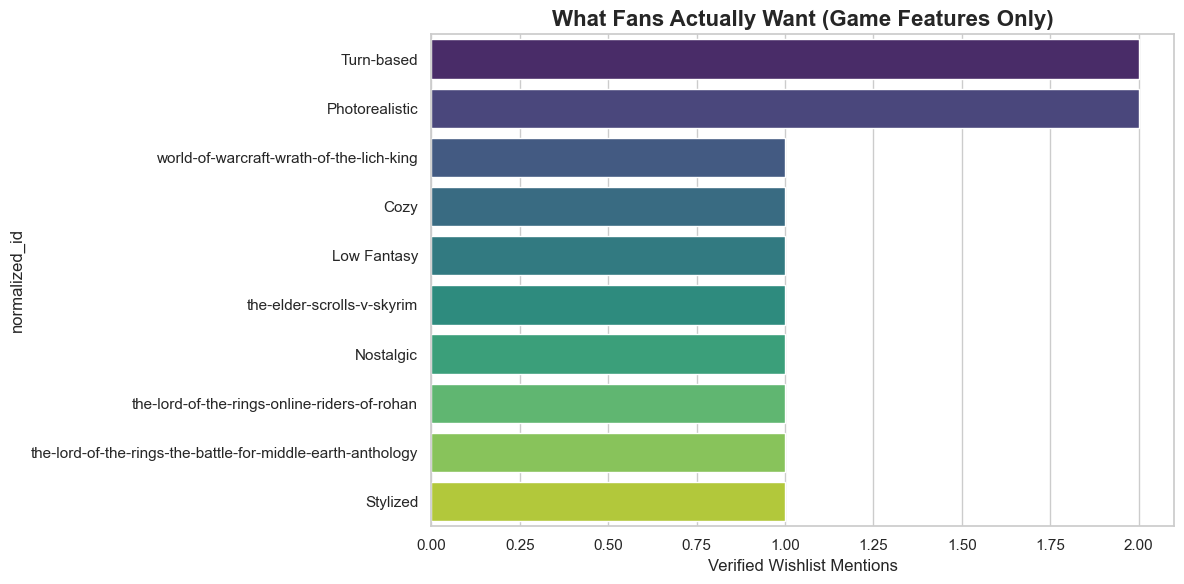

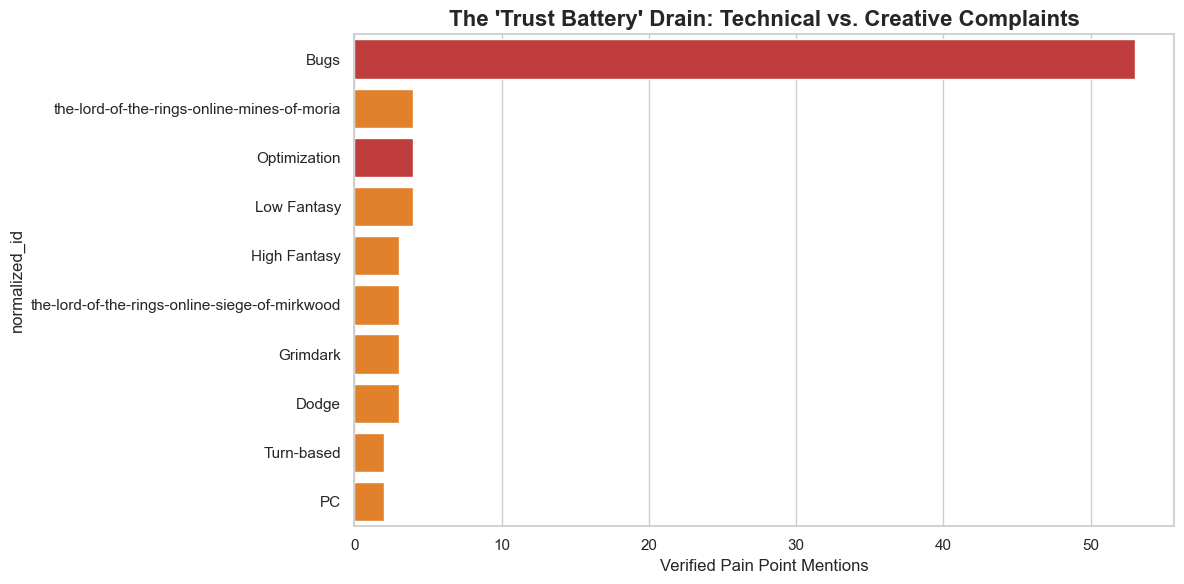

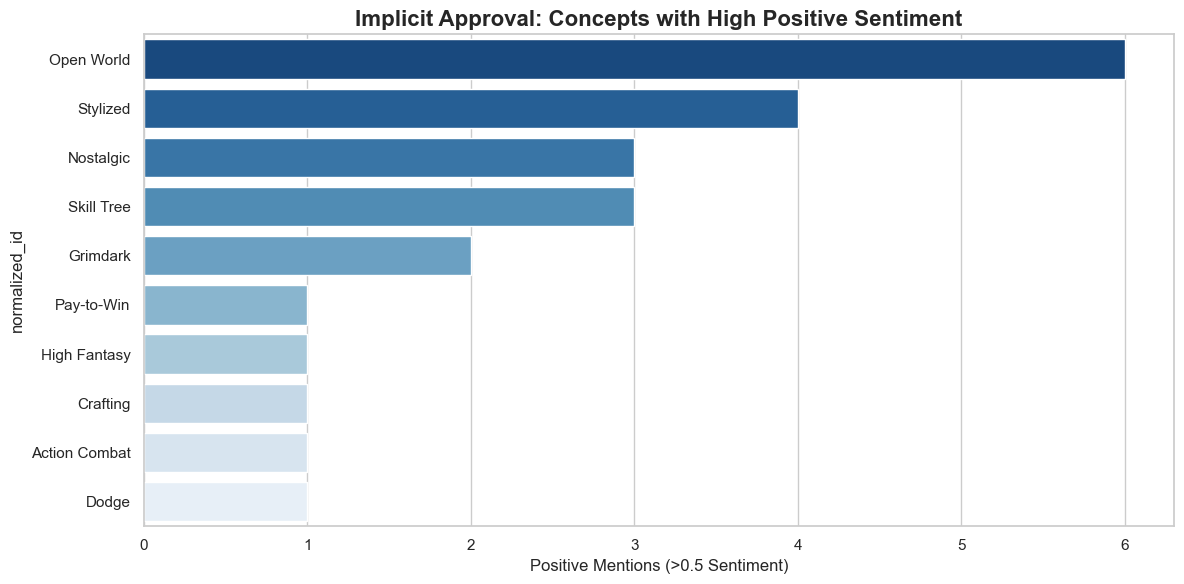

In [23]:
# ==============================================================================
# CELL 8: VISUALIZATION GENERATOR (FOR PPT DECK)
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load Master Data if not already in memory
try:
    df = pd.read_csv("Embracer_Reddit_Signals_MASTER_v1.csv")
except:
    print("Master CSV not found. Please re-run the batch processor.")
    df = pd.DataFrame()

if not df.empty:
    # SET STYLE
    sns.set_theme(style="whitegrid")
    
    # --- CHART 1: THE "REAL" WISHLIST (No Tech/PC Noise) ---
    plt.figure(figsize=(12, 6))
    
    # Filter: Intent=WISHLIST, Exclude Category=TECH, Exclude "PC"
    wishlist_data = df[
        (df['intent'] == 'WISHLIST') & 
        (df['category'] != 'TECH') & 
        (df['normalized_id'] != 'PC')
    ]['normalized_id'].value_counts().head(10)
    
    sns.barplot(x=wishlist_data.values, y=wishlist_data.index, palette="viridis")
    plt.title("What Fans Actually Want (Game Features Only)", fontsize=16, weight='bold')
    plt.xlabel("Verified Wishlist Mentions", fontsize=12)
    plt.tight_layout()
    plt.savefig("Slide1_Real_Wishlist.png", dpi=300)
    print("✅ Saved 'Slide1_Real_Wishlist.png'")
    
    # --- CHART 2: THE "PAIN LANDSCAPE" (Tech vs Design) ---
    plt.figure(figsize=(12, 6))
    
    pain_data = df[df['intent'] == 'PAIN_POINT']['normalized_id'].value_counts().head(10)
    
    # Color Code: RED for Tech (Bugs), ORANGE for Design (Lore/Mechanics)
    colors = ['#d62728' if x in ['Bugs', 'Optimization', 'Console'] else '#ff7f0e' for x in pain_data.index]
    
    sns.barplot(x=pain_data.values, y=pain_data.index, palette=colors)
    plt.title("The 'Trust Battery' Drain: Technical vs. Creative Complaints", fontsize=16, weight='bold')
    plt.xlabel("Verified Pain Point Mentions", fontsize=12)
    plt.tight_layout()
    plt.savefig("Slide2_Pain_Points.png", dpi=300)
    print("✅ Saved 'Slide2_Pain_Points.png'")

    # --- CHART 3: THE "HIDDEN LOVE" (Implicit Sentiment) ---
    # What do they like even if they don't say "I wish"?
    plt.figure(figsize=(12, 6))
    
    implicit_love = df[
        (df['sentiment'] > 0.5) & 
        (df['category'].isin(['MECHANIC', 'AESTHETIC']))
    ]['normalized_id'].value_counts().head(10)
    
    sns.barplot(x=implicit_love.values, y=implicit_love.index, palette="Blues_r")
    plt.title("Implicit Approval: Concepts with High Positive Sentiment", fontsize=16, weight='bold')
    plt.xlabel("Positive Mentions (>0.5 Sentiment)", fontsize=12)
    plt.tight_layout()
    plt.savefig("Slide3_Implicit_Love.png", dpi=300)
    print("✅ Saved 'Slide3_Implicit_Love.png'")
    
else:
    print("No data to plot.")